### Model Creation - Multi Layer Perceptron
Paper:  
Sigmoid activation function has been considered in this work
as the non-linear transfer function of each neuron. We utilized the
Scikit-Learn library [32] in Python to create the model

**Imports:**

In [57]:
import torch
import csv
from torch.utils.data import random_split
from matplotlib import pyplot
import pandas as pd
import torch



#### Dataset Loading

In [59]:
def prepare_dataset(dataset_files, delimiter=";"):
  
    dataframes = []
    data_path = "../data/"
    
    for file in dataset_files:
      df = pd.read_csv(data_path+file, delimiter=delimiter)
              
      label = 0
      if "atk" in file:
        df.drop(df.columns[0], axis=1, inplace=True) # drop index-column
        label = 1
      df["label"] = label
            
      dataframes.append(df)
        
    concatenated_df = pd.concat(dataframes, axis=0)
    concatenated_df.replace({True: 1, False: 0}, inplace=True) # convert boolean to numbers    
    concatenated_df.drop(columns=["blockNumber", "address"], inplace=True)

    # Convert dataframe to torch tensor
    data_tensor = torch.tensor(concatenated_df.values, dtype=torch.float)
    
    # Get the input (data samples) without the target information
    X = data_tensor[:, :-1]
    
    # Get the target information
    T = data_tensor[:, -1].unsqueeze(1)

    print("Features: ", concatenated_df.columns)

    print(f"Loaded dataset with {len(concatenated_df)} samples")
    
    return X, T


In [36]:
dataset_files = ["insertion_atks_first_atk_2500.csv", "insertion_atks_second_atk_2500.csv", "random_sampled_transactions.csv"]

X, T = prepare_dataset(dataset_files, ",")

Features:  Index(['gasPrice', 'meanGasPriceLastTenBlocks', 'stdGasPriceLastTenBlocks',
       'meanGasPriceLastTenBlocksSameEOA', 'stdGasPriceLastTenBlocksSameEOA',
       'usedGasToken', 'predictedGasPrice', 'label'],
      dtype='object')
Loaded dataset with 9821 samples


#### Split Training and Validation Data

In [60]:
def split_training_data(X, T, train_percentage=0.8):
  
  assert len(X) == len(T)
  
  num_samples = len(X)
  
  train_size = int(train_percentage * num_samples)
  validation_size = num_samples - train_size
    
  # split into 80/20 training/validation
  idx_train, idx_validation = random_split(range(num_samples), [train_size, validation_size])

  
  X_train = X[idx_train]
  T_train = T[idx_train]
  X_val = X[idx_validation]
  T_val = T[idx_validation]

  return X_train, T_train, X_val, T_val

#### Input Data Standardization

In [61]:
def standardize(X_train, X_val):
  # compute statistics
  mean = X_train.mean(dim=0)
  std = X_train.std(dim=0)

  # Check if standard deviation is zero
  zero_std_mask = std == 0
  
  # Standardize both X_train and X_val, excluding columns with zero standard deviation
  X_train = (X_train - mean) / std.masked_fill(zero_std_mask, 1)  # Replace zero std with 1 to avoid division by zero
  X_val = (X_val - mean) / std.masked_fill(zero_std_mask, 1)

  return X_train, X_val

### Network Implementation

**Network Architecture**
- 1 input layer
  - 7 input neurons
- 2 hidden layers
  - 10 hidden neurons
  - 10 hidden neurons
- 1 output layer
  - 1 output neuron    

Using Sigmoid Activation function!

In [62]:
def Network(input_layer_size, hidden_layer_size, output_layer_size):
    return torch.nn.Sequential(
        torch.nn.Linear(input_layer_size, hidden_layer_size),      # Input layer to first hidden layer
        torch.nn.Sigmoid(),                                        # Sigmoid activation function for the first hidden layer
        torch.nn.Linear(hidden_layer_size, hidden_layer_size),     # First hidden layer to second hidden layer
        torch.nn.Sigmoid(),                                        # Sigmoid activation function for the second hidden layer
        torch.nn.Linear(hidden_layer_size, output_layer_size)      # Second hidden layer to output layer
    )

**Training Loop**

In [63]:
def accuracy(Z, T):
  # binary classification
  z_sign = (Z >= 0).int()
  return torch.mean((z_sign == T).float())

In [64]:
def train(network, loss, X_train, T_train, X_val, T_val, num_epochs=10000, learning_rate=0.1):
  
  optimizer = torch.optim.SGD(
    params=network.parameters(),
    lr=learning_rate
  )

  # collect loss and accuracy values
  train_loss, train_acc, val_loss, val_acc = [], [], [], []

  for epoch in range(num_epochs):
    # train on training set
    optimizer.zero_grad()
    # ... compute network output on training data
    Z = network(X_train)
    if Z.shape[1] > 1:
      T_train = torch.flatten(T_train)
    
    # ... compute loss from network output and target data
    J = loss(Z, T_train)
    J.backward()
    # ... perform parameter update
    optimizer.step()
    # ... remember loss
    train_loss.append(J.item())
    # ... compute training set accuracy
    train_acc.append(accuracy(Z, T_train).item())

    # test on validation data
    with torch.no_grad():
      # ... compute network output on validation data
      Z = network(X_val)
      if Z.shape[1] > 1:
        T_val = torch.flatten(T_val)
      # ... compute loss from network output and target data
      J = loss(Z, T_val)
      # ... remember loss
      val_loss.append(J.item())
      # ... compute validation set accuracy
      val_acc.append(accuracy(Z, T_val).item())

  # return the four lists of losses and accuracies
  return train_loss, train_acc, val_loss, val_acc

In [65]:
def plot(train_loss, train_acc, val_loss, val_acc):
  pyplot.figure(figsize=(10,3))
  ax = pyplot.subplot(121)
  ax.plot(train_loss, "g-", label="Training set loss")
  ax.plot(val_loss, "b-", label="Validation set loss")
  ax.legend()

  ax = pyplot.subplot(122)
  ax.plot(train_acc, "g-", label="Training set accuracy")
  ax.plot(val_acc, "b-", label="Validation set accuracy")
  ax.legend()

Features:  Index(['gasPrice', 'meanGasPriceLastTenBlocks', 'stdGasPriceLastTenBlocks',
       'meanGasPriceLastTenBlocksSameEOA', 'stdGasPriceLastTenBlocksSameEOA',
       'usedGasToken', 'predictedGasPrice', 'label'],
      dtype='object')
Loaded dataset with 9821 samples


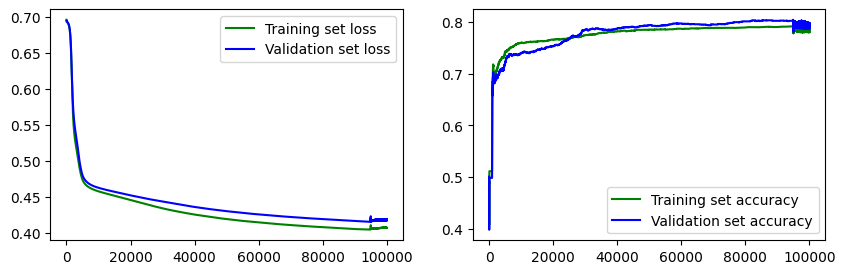

In [70]:
# Load dataset
dataset_files = ["insertion_atks_first_atk_2500.csv", "insertion_atks_second_atk_2500.csv", "random_sampled_transactions.csv"]
X, T = prepare_dataset(dataset_files, ",")

# Split dataset
X_train, T_train, X_val, T_val = split_training_data(X, T, 0.8)
# Standardize input data
X_train, X_val = standardize(X_train, X_val)

# Initiate the network
network = Network(7, 10, 1)
# Define loss function
loss = torch.nn.BCEWithLogitsLoss(reduction="mean")

# Train network on our data
results = train(network, loss, X_train, T_train, X_val, T_val, num_epochs=100000, learning_rate=0.1)
train_loss, train_acc, val_loss, val_acc = results

# plot the results
plot(train_loss, train_acc, val_loss, val_acc)

In [45]:
X_train

tensor([[-0.0283,  1.6396, -0.0669,  ..., -0.1745,  0.0000,  1.0750],
        [-0.1896, -0.7554, -0.1821,  ..., -0.1729,  0.0000,  0.0000],
        [ 6.8279,  0.7829,  1.3170,  ..., 10.3910,  0.0000,  1.0750],
        ...,
        [-0.1417, -0.0433, -0.1449,  ..., -0.1745,  0.0000,  1.0750],
        [-0.0451,  0.9077, -0.0585,  ..., -0.1683,  0.0000,  1.0750],
        [-0.1983, -0.8940, -0.1869,  ..., -0.1745,  0.0000,  0.0000]])

#### Comparison to other models

**Random Forest**

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100)

# Train the classifier on the training data
random_forest.fit(X_train, T_train)

# Make predictions on the testing data
predictions = random_forest.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(T_val, predictions)
print("Accuracy:", accuracy)

/home/nico/.local/lib/python3.10/site-packages/sklearn/base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.8147582697201018


**NN with sklearn**

In [53]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(10,), activation='logistic', solver='adam', max_iter=10000)

# Train the classifier on the training data
mlp.fit(X_train, T_train)

predictions = mlp.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(T_val, predictions)
print("Accuracy:", accuracy)

/home/nico/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1102: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.7628498727735369
